In [4]:
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 39.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.2 which is incompatible.


In [10]:
import os
import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout
from scikeras.wrappers import KerasClassifier, KerasRegressor

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data Preprocessing

In [2]:
def preprocess():
    # Data paths
    train_data_file = 'sign_mnist_train.csv'
    test_data_file = 'sign_mnist_test.csv'
    folder_name = 'Project Data'

    # desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
    # train_data_path = os.path.join(desktop_path, folder_name, train_data_file)
    # test_data_path = os.path.join(desktop_path, folder_name, test_data_file)
    train_data_path = f'/content/drive/My Drive/{train_data_file}'
    test_data_path = f'/content/drive/My Drive/{test_data_file}'

    # Load data
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    train_labels = train_df['label']
    train = train_df.drop(['label'], axis=1)

    test_labels = test_df['label']
    test = test_df.drop(['label'], axis=1)

    # Reshaping images
    train_images = train.values
    train_images = np.array([np.reshape(i, (28, 28)) for i in train_images])
    train_images = np.array([i.flatten() for i in train_images])

    test_images = test.values
    test_images = np.array([np.reshape(i, (28, 28)) for i in test_images])
    test_images = np.array([i.flatten() for i in test_images])

    # One hot encoding labels
    binrizer = LabelBinarizer()
    train_labels = binrizer.fit_transform(train_labels)
    test_labels = binrizer.fit_transform(test_labels)

    # Split into train and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

    # Normalize pixel values [0, 1]
    X_train = X_train/ 255.0
    X_valid = X_valid / 255.0

    # Reshape to 4D array (CNN)
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_valid = X_valid.reshape(X_valid.shape[0], 28, 28, 1)
    test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

    return X_train, X_valid, test_images, y_train, y_valid, test_labels

X_train, X_valid, test_images, y_train, y_valid, test_labels = preprocess()

I. Hyperparameter Tuning

In [14]:
def create_model(optimizer='adam', kernel_size=(3, 3), pool_size=(2, 2), dropout_rate=0.2):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=kernel_size, activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(32, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(64, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=24, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=128, verbose=1)

# Define hyperparameters to tune
param_grid = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__kernel_size': [(3, 3), (5, 5)],
    'model__pool_size': [(2, 2), (3, 3)],
    'model__dropout_rate': [0.2, 0.3]
}

# Perform Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

# Print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.0706 - loss: 3.1174
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3165 - loss: 2.0923
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5657 - loss: 1.3233
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6885 - loss: 0.9129
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7579 - loss: 0.7003
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8182 - loss: 0.5395
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8596 - loss: 0.4084
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8948 - loss: 0.3194
Epoch 9/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9136 - loss: 0.2640
Epoch 10/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9312 - loss: 0.2116
Epoch 11/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9521 - loss: 0.1610
Epoch 12/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.0819 - loss: 3.0956
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3267 - loss: 2.0683
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5520 - loss: 1.3402
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6777 - loss: 0.9482
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7495 - loss: 0.7372
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7993 - loss: 0.5835
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8388 - loss: 0.4736
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8700 - loss: 0.3785
Epoch 9/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8926 - loss: 0.3226
Epoch 10/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9184 - loss: 0.2515
Epoch 11/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9291 - loss: 0.2167
Epoch 12/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.0786 - loss: 3.1094
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.2913 - loss: 2.2125
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5082 - loss: 1.4728
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6564 - loss: 1.0176
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7424 - loss: 0.7685
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8035 - loss: 0.5760
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8365 - loss: 0.4750
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8742 - loss: 0.3669
Epoch 9/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9053 - loss: 0.2930
Epoch 10/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9269 - loss: 0.2322
Epoch 11/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9365 - loss: 0.1953
Epoch 12/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.0783 - loss: 3.1099
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2360 - loss: 2.4649
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3917 - loss: 1.8637
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5105 - loss: 1.4540
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6107 - loss: 1.1488
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6764 - loss: 0.9355
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7385 - loss: 0.7619
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7885 - loss: 0.6192
Epoch 9/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8242 - loss: 0.5082
Epoch 10/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8685 - loss: 0.3966
Epoch 11/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8920 - loss: 0.3215
Epoch 12/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.0699 - loss: 3.1240
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2141 - loss: 2.5330
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3359 - loss: 2.0546
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4357 - loss: 1.7170
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5257 - loss: 1.4284
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6225 - loss: 1.1399
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6936 - loss: 0.9136
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7534 - loss: 0.7324
Epoch 9/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8141 - loss: 0.5710
Epoch 10/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8505 - loss: 0.4354
Epoch 11/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8936 - loss: 0.3249
Epoch 12/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.0669 - loss: 3.1367
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2310 - loss: 2.4855
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4041 - loss: 1.8739
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5185 - loss: 1.4604
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5931 - loss: 1.1939
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6711 - loss: 0.9758
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7240 - loss: 0.8001
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7772 - loss: 0.6520
Epoch 9/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8189 - loss: 0.5430
Epoch 10/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8483 - loss: 0.4592
Epoch 11/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8740 - loss: 0.3793
Epoch 12/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequ

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequ

Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.0800 - loss: 3.0881
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3691 - loss: 1.9397
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5773 - loss: 1.2488
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6882 - loss: 0.9181
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7459 - loss: 0.7369
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8023 - loss: 0.5983
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8373 - loss: 0.4928
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8677 - loss: 0.4049
Epoch 9/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8871 - loss: 0.3411
Epoch 10/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9112 - loss: 0.2771
Epoch 11/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9336 - loss: 0.2170
Epoch 12/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.0726 - loss: 3.1266
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3521 - loss: 1.9849
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6016 - loss: 1.1758
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6872 - loss: 0.9049
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7590 - loss: 0.7024
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8115 - loss: 0.5574
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8461 - loss: 0.4559
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8790 - loss: 0.3521
Epoch 9/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9036 - loss: 0.2878
Epoch 10/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9186 - loss: 0.2410
Epoch 11/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9381 - loss: 0.1898
Epoch 12/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.0856 - loss: 3.0965
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4099 - loss: 1.8316
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5866 - loss: 1.2085
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6760 - loss: 0.9366
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7360 - loss: 0.7719
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7864 - loss: 0.6082
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8305 - loss: 0.4937
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8700 - loss: 0.3897
Epoch 9/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8908 - loss: 0.3320
Epoch 10/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9089 - loss: 0.2740
Epoch 11/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9199 - loss: 0.2417
Epoch 12/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.0750 - loss: 3.1247
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2209 - loss: 2.4703
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3517 - loss: 2.0129
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4538 - loss: 1.6670
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5564 - loss: 1.3392
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6435 - loss: 1.0674
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7194 - loss: 0.8456
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7562 - loss: 0.7183
Epoch 9/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8059 - loss: 0.5712
Epoch 10/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8372 - loss: 0.4849
Epoch 11/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8698 - loss: 0.3923
Epoch 12/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.0708 - loss: 3.1252
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1873 - loss: 2.6126
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3092 - loss: 2.1081
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4286 - loss: 1.7052
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5391 - loss: 1.3786
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6197 - loss: 1.1144
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6901 - loss: 0.9185
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7492 - loss: 0.7388
Epoch 9/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7976 - loss: 0.5882
Epoch 10/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8337 - loss: 0.4929
Epoch 11/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8620 - loss: 0.4115
Epoch 12/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.0690 - loss: 3.1245
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2190 - loss: 2.4964
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3825 - loss: 1.9082
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5189 - loss: 1.4882
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6145 - loss: 1.1539
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6781 - loss: 0.9453
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7360 - loss: 0.7744
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7827 - loss: 0.6240
Epoch 9/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8196 - loss: 0.5159
Epoch 10/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8567 - loss: 0.4166
Epoch 11/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8863 - loss: 0.3381
Epoch 12/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequ

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequ

Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.0762 - loss: 3.0776
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2849 - loss: 2.2473
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4718 - loss: 1.5961
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6173 - loss: 1.1443
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7149 - loss: 0.8401
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7872 - loss: 0.6273
Epoch 7/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8429 - loss: 0.4668
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8800 - loss: 0.3556
Epoch 9/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9121 - loss: 0.2629
Epoch 10/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9361 - loss: 0.1934
Epoch 11/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9545 - loss: 0.1398
Epoch 12/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

II. Training Model

In [24]:
# CNN Model
model = Sequential()
model.add(Conv2D(16 , kernel_size=(3,3), activation='relu' , input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32 , kernel_size=(3,3), activation='relu' , input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64 , kernel_size=(3,3), activation='relu' , input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 24 , activation = 'softmax'))

# Experimentation
# 1 - epochs=10, batch_size=128, accuracy score=0.6865588399330731
# 2 - epoch=50, batch_size=128, accuracy score = 0.9125766871165644

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size=128)
model.save('cnn.h5')

Epoch 1/50
172/172 [==============================] - 4s 9ms/step - loss: 2.6681 - accuracy: 0.1943 - val_loss: 1.6721 - val_accuracy: 0.4912
Epoch 2/50
172/172 [==============================] - 1s 8ms/step - loss: 1.3619 - accuracy: 0.5490 - val_loss: 0.9352 - val_accuracy: 0.6984
Epoch 3/50
172/172 [==============================] - 1s 8ms/step - loss: 0.8780 - accuracy: 0.7041 - val_loss: 0.6445 - val_accuracy: 0.7964
Epoch 4/50
172/172 [==============================] - 1s 6ms/step - loss: 0.6285 - accuracy: 0.7857 - val_loss: 0.4770 - val_accuracy: 0.8406
Epoch 5/50
172/172 [==============================] - 1s 5ms/step - loss: 0.4573 - accuracy: 0.8490 - val_loss: 0.3183 - val_accuracy: 0.8991
Epoch 6/50
172/172 [==============================] - 1s 5ms/step - loss: 0.3308 - accuracy: 0.8887 - val_loss: 0.2126 - val_accuracy: 0.9383
Epoch 7/50
172/172 [==============================] - 1s 5ms/step - loss: 0.2445 - accuracy: 0.9201 - val_loss: 0.1722 - val_accuracy: 0.9474
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
# Test model
y_pred = model.predict(test_images)
print("Test Accuracy:", accuracy_score(test_labels, y_pred.round()))

225/225 [==============================] - 1s 3ms/step
Test Accuracy: 0.9125766871165644


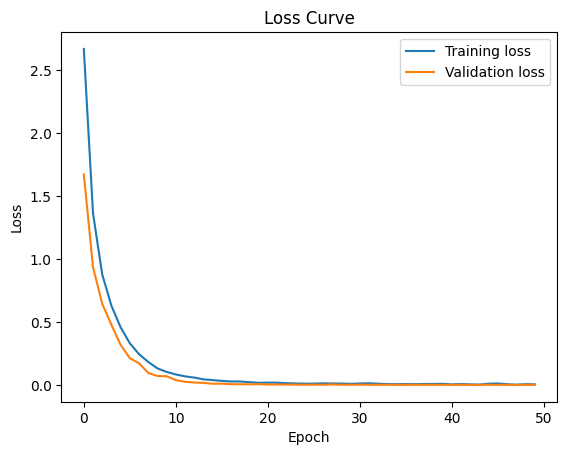

In [26]:
# Learning curve for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss Curve")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])
plt.show()